In [1]:
# Importing modules
import pandas as pd
import numpy as np
from scripts.preprocessing_omicron import preprocess
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import joblib

In [2]:
# Data for training and validation
train_data = preprocess("data/train_set").spectra2df()
train_data = train_data.loc[train_data["Class"].isin(["BA1", "BA2", "BA5", "XBB"])]

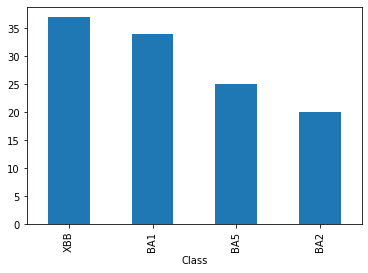

In [3]:
# Class distribution (Training and validation set)
train_data["Class"].value_counts().plot.bar()
plt.show()

# Here BA2-BA5 means either the variant is BA2 or BA5 
# similarly for BA1-BA2 either it is BA1 or BA2
# Well defined classes are only for isolates not for clinical data

In [4]:
# Target labels
y = train_data["Class"]

# Feature matrix
X = train_data.drop(["Class", "Sample"], axis=1) 

# Training and validation split (80:20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Oversampling training set
oversampler = SMOTE(random_state=42)
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

# Scaling training and validation set
sds = StandardScaler()
scaled_X_train = pd.DataFrame(sds.fit_transform(X_train_os), columns=X_train_os.columns)
scaled_X_val = pd.DataFrame(sds.transform(X_val), columns=X_val.columns)
joblib.dump(sds, "models/scaler_omicron1.pkl") # Saving scaler params

['models/scaler_omicron1.pkl']

In [5]:
# Model 
classifier = SVC(random_state=42, probability=True)

# Best parameters found after hyperparameter tuning 
params = {"C": [10], "kernel": ["rbf"], "gamma": ["scale"]}

# Model training with 5 fold cv 
grid_search = GridSearchCV(classifier, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(scaled_X_train.to_numpy(), y_train_os)

# Final model
model = grid_search.best_estimator_

In [6]:
# Model Validation
y_pred_val = model.predict(scaled_X_val.to_numpy())

In [7]:
# Classification report (Validation set)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

         BA1       1.00      1.00      1.00         7
         BA2       1.00      0.75      0.86         4
         BA5       0.83      1.00      0.91         5
         XBB       1.00      1.00      1.00         8

    accuracy                           0.96        24
   macro avg       0.96      0.94      0.94        24
weighted avg       0.97      0.96      0.96        24



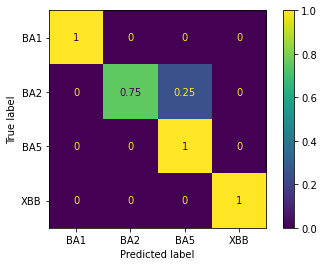

In [8]:
# Confusion matrix (Validation set)
cmat = confusion_matrix(y_val, y_pred_val, normalize="true")
disp_cmat = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=model.classes_)
disp_cmat.plot()
plt.show()

In [9]:
# Saving final SVM model
joblib.dump(model, "models/SVM_omicron_model1.pkl")

['models/SVM_omicron_model1.pkl']